In [1]:
using Catalyst
using DifferentialEquations, Plots

# Intermediary Stage

In [127]:
# system where x is a species, y is the predator of x, and z is the predator of y
# yy is a y that has eaten a x and can reproduce and zz is a z that has eaten a y and can reproduce
rn = @reaction_network begin
    c1, X --> 2X # reproduction of X
    c2, YY --> 2Y # reproduction of Y
    c3, ZZ --> 2Z # reproduction of Z
    c4, X + Y --> YY # predation of X by Y
    c5, Y + Z --> ZZ # predation of Y by Z
    c6, X --> 0 # death of X
    c7, (Y, YY) --> 0 # death of Y
    c8, (Z, ZZ) --> 0 # death of Z
end

p = (:c1 => 1.5, :c2 => 0.8, :c3 => 0.4, :c4 => 0.05, :c5 => 0.01, :c6 => 1.1, :c7 => 0.5, :c8 => 0.1)
tspan = (0.,10.)
u0 = [:X => 1700., :Y => 200., :Z => 3., :YY => 0., :ZZ => 0.]
dt = 0.01

0.01

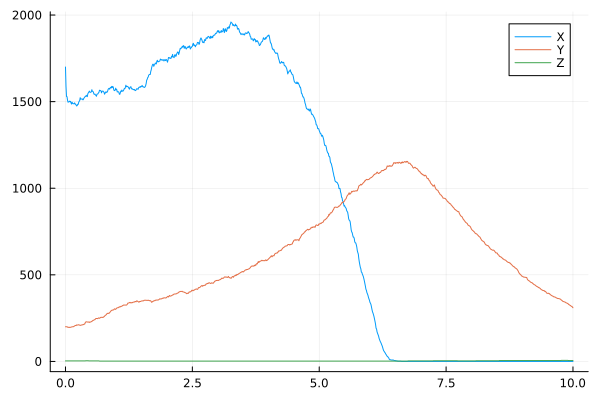

In [128]:
dprob = DiscreteProblem(rn, u0, tspan, p)
jprob = JumpProblem(rn, dprob, Direct())
jsol = solve(jprob, SSAStepper(), saveat = dt)
dataset = reduce(hcat, jsol.u)'
inds = [jsol.t[i] in tspan[1]:dt:tspan[2] for i in 1:length(jsol.t)]
dataset = dataset[inds, :]
u = [dataset[:, 1] dataset[:, 2].+dataset[:, 3] dataset[:, 4].+dataset[:, 5]]
plot(jsol.t[inds], u, labels = ["X" "Y" "Z"])

# No intermediary

In [199]:
# system where x is a species, y is the predator of x, and z is the predator of y
rn = @reaction_network begin
    c1, X --> 2X # reproduction of X
    c2, X + Y --> 2Y # predation of X by Y
    c3, Y + Z --> 2Z # predation of Y by Z
    c4, X --> 0 # death of X
    c5, Y --> 0 # death of Y
    c6, Z --> 0 # death of Z
end

p = (:c1 => 1.5, :c2 => 1e-3, :c3 => 1e-3, :c4 => 1.1, :c5 => 0.9, :c6 => 0.4)
tspan = (0.,30.)
u0 = [:X => 1700., :Y => 50., :Z => 10.]
dt = 0.1

0.1

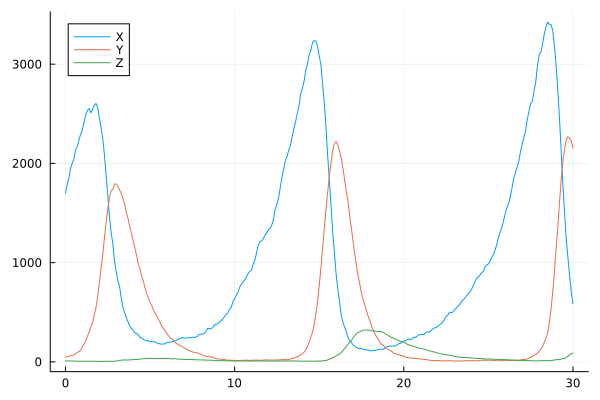

In [200]:
condition1(u, t, integrator) = u[1] > 1e6
condition2(u, t, integrator) = u[1] == 0
condition3(u, t, integrator) = u[2] == 0
condition4(u, t, integrator) = u[3] == 0
affect!(integrator) = terminate!(integrator)
cbs = CallbackSet(DiscreteCallback(condition1, affect!), DiscreteCallback(condition2, affect!), DiscreteCallback(condition3, affect!), DiscreteCallback(condition4, affect!))
dprob = DiscreteProblem(rn, u0, tspan, p)
jprob = JumpProblem(rn, dprob, Direct())
jsol = solve(jprob, SSAStepper(), saveat = dt, callback = cbs)
dataset = reduce(hcat, jsol.u)'
inds = [jsol.t[i] in tspan[1]:dt:tspan[2] for i in 1:length(jsol.t)]
dataset = dataset[inds, :]
u = [dataset[:, 1] dataset[:, 2] dataset[:, 3]]
# cutoff any data from u the moment that any of the species goes extinct
ts = jsol.t[inds]
for i in 1:size(u, 1)
    if u[i, 1] == 0 || u[i, 2] == 0 || u[i, 3] == 0
        u = u[1:i, :]
        ts = ts[1:i]
        break
    end
end
plot(ts, u, labels = ["X" "Y" "Z"])

# SINDy

In [201]:
using ModifiedSINDy

In [202]:
function normalize_data(data::AbstractMatrix)
    # normalize data to be between 0 and 1
    data_norm = zeros(size(data))
    for i in 1:size(data, 2)
        data_norm[:, i] = data[:, i]./maximum(data[:, i])
    end
    return data_norm
end

normalize_data (generic function with 1 method)

In [213]:
basis = [
    BasisTerm(u -> u[:, 1]),
    BasisTerm(u -> u[:, 2]),
    BasisTerm(u -> u[:, 3]),
    BasisTerm(u -> u[:, 1] .* u[:, 2]),
    BasisTerm(u -> u[:, 3] .* u[:, 2]),
    BasisTerm(u -> u[:, 1] .* u[:, 3]),
    BasisTerm(u -> u[:, 1] .^ 2),
    BasisTerm(u -> u[:, 2] .^ 2),
    BasisTerm(u -> u[:, 3] .^ 2),
    BasisTerm(u -> u[:, 1] .* u[:, 2] .* u[:, 3]),
]

small_basis = [
    BasisTerm(u -> u[:, 1]),
    BasisTerm(u -> u[:, 2]),
    BasisTerm(u -> u[:, 3]),
    BasisTerm(u -> u[:, 1] .* u[:, 2]),
    BasisTerm(u -> u[:, 3] .* u[:, 2])
]

dt = 1

expected_i = [1 0 0; 0 1 0; 0 0 1; 1 1 0; 0 1 1; 0 0 0; 0 0 0; 0 0 0; 0 0 0; 0 0 0]
small_expected_i = [1 0 0; 0 1 0; 0 0 1; 1 1 0; 0 1 1]

print("Expected coefficients:")
expected_i

Expected coefficients:

10×3 Matrix{Int64}:
 1  0  0
 0  1  0
 0  0  1
 1  1  0
 0  1  1
 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0

301×3 Matrix{Float64}:
 0.49635   0.0220459  0.0311526
 0.520876  0.0216049  0.0280374
 0.540146  0.0242504  0.0280374
 0.569343  0.0273369  0.0280374
 0.584234  0.0291005  0.0280374
 0.598248  0.0299824  0.0249221
 0.623358  0.037478   0.0218069
 0.633869  0.042328   0.0218069
 0.653431  0.0454145  0.0186916
 0.670657  0.0529101  0.0186916
 ⋮                    
 0.72      0.701058   0.0716511
 0.62365   0.806437   0.0841121
 0.52438   0.890653   0.0996885
 0.442336  0.943563   0.109034
 0.361752  0.986772   0.140187
 0.308029  1.0        0.174455
 0.253723  0.992504   0.214953
 0.204672  0.981481   0.252336
 0.171387  0.948854   0.271028

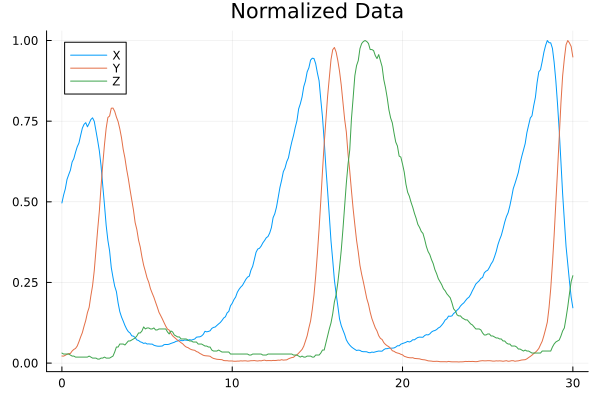

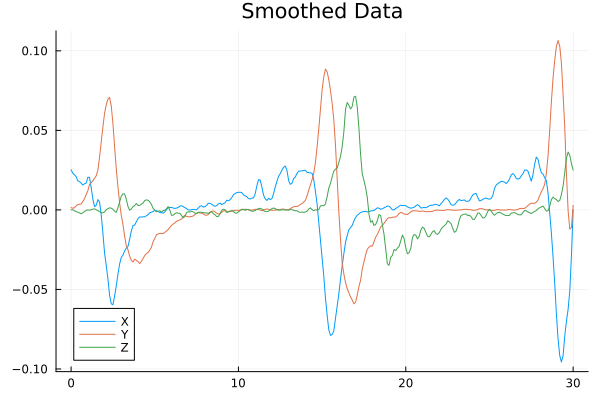

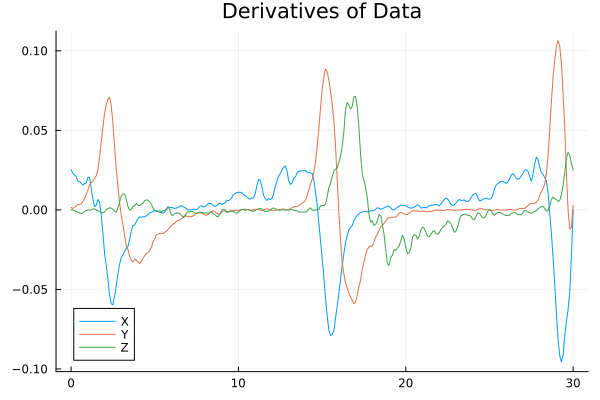

In [239]:
un = normalize_data(u)
data_plot = plot(ts, un, labels = ["X" "Y" "Z"], title = "Normalized Data")
display(data_plot)
ues, dues = SG_smoothing_optim(un, dt; loss_function = 2, disp_loss_landscape = false)
smoothed_plot = plot(ts, dues, labels = ["X" "Y" "Z"], title = "Smoothed Data")
display(smoothed_plot)
deriv_plot = plot(ts, dues, labels = ["X" "Y" "Z"], title = "Derivatives of Data")
display(deriv_plot)

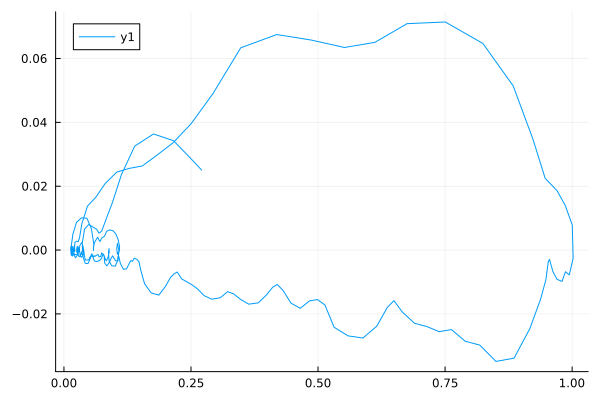

In [227]:
i = 3
plot(ues[:, i], dues[:, i])

In [228]:
#basic SINDy
iter = 10
prob = SINDy_Problem(ues, dues, dt, basis, iter; STRRidge = false)
batches = 100; pct_size = 0.8; tol = 0.95; parallel = true
m, l = ensemble_solve_SINDy(prob,batches, pct_size, tol, parallel)
display(m)
display(l)

10×3 Matrix{AbstractFloat}:
  0.0400696   0.0         0.0
  0.0        -0.0881029   0.0
  0.0         0.0        -0.0420834
 -0.226594    0.327882    0.0
  0.0        -0.038857    0.225183
  0.0         0.0         0.0
  0.0         0.0         0.0
  0.0         0.0         0.0
  0.0         0.0         0.0
  0.0         0.138392    0.0

10×3 Matrix{Float64}:
 1.0   0.0   0.0
 0.0   1.0   0.0
 0.0   0.0   1.0
 1.0   1.0   0.0
 0.0   1.0   1.0
 0.01  0.0   0.08
 0.0   0.0   0.0
 0.0   0.0   0.0
 0.0   0.0   0.0
 0.4   0.96  0.2

In [229]:
# New SINDy algorithm
iter = 10
cs = exp10.(-10:0.1:-1)
tspan = (0, 1000-5)
batches = 1000; pct_size = 0.9; tol = 0.95; parallel = true

alg = PFA([], tspan, cs, 1, nothing, 0.8)
prob = SINDy_Problem(ues, dues, dt, basis, iter, alg; STRRidge = true, )
m, l = ensemble_solve_SINDy(prob,batches, pct_size, tol, parallel)
display(m)
display(l)

10×3 Matrix{AbstractFloat}:
  0.0398545   0.0         0.0
  0.0        -0.0848668   0.0
  0.0         0.0        -0.0415521
 -0.225488    0.328955    0.0
  0.0        -0.0334832   0.222534
  0.0         0.0         0.0
  0.0         0.0         0.0
  0.0         0.0         0.0
  0.0         0.0         0.0
  0.0         0.0         0.0

10×3 Matrix{Float64}:
 1.0    0.017  0.0
 0.003  1.0    0.017
 0.004  0.002  1.0
 1.0    1.0    0.025
 0.002  1.0    1.0
 0.433  0.037  0.039
 0.001  0.017  0.0
 0.004  0.013  0.005
 0.001  0.016  0.022
 0.708  0.94   0.045

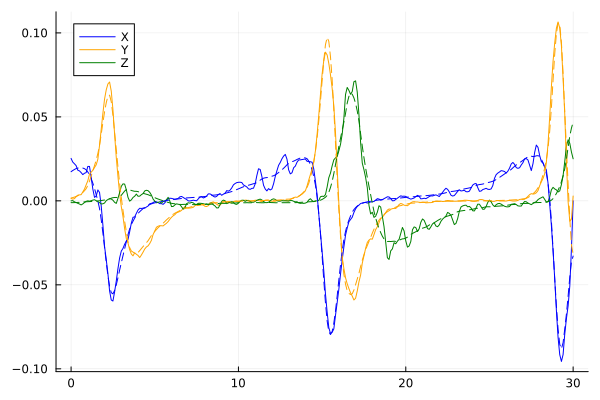

In [237]:
des = Matrix{Float16}(prob.Θ * m)
plot(ts, dues, labels = ["X" "Y" "Z"], c = [:blue :orange :green])
plot!(ts, des, ls = :dash, c = [:blue :orange :green], label = false)

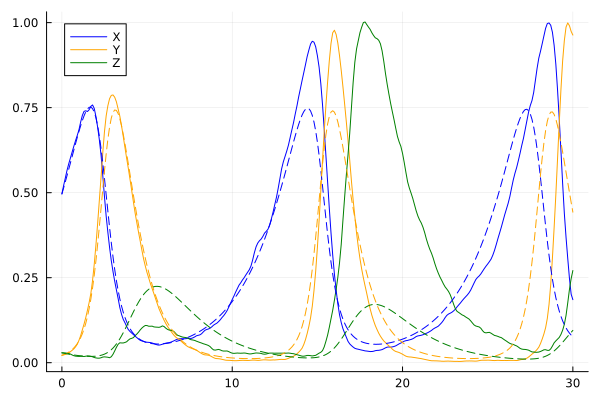

In [238]:
traj = get_trajectory(prob, m)
plot(ts, ues, labels = ["X" "Y" "Z"], c = [:blue :orange :green])
plot!(ts, traj, ls = :dash, c = [:blue :orange :green], label = false)